# Setup

In [1]:
import os
import gc
import numpy as np
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Configure TensorFlow to allocate GPU memory on demand rather than pre-allocating the entire GPU memory.
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled")
    except:
        print("Failed to set memory growth")
else:
    print("No GPU devices available")

Num GPUs Available:  1
GPU memory growth enabled


# Load the training Images

In [3]:
training_images_path = 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/'

image_size = (64, 64)
batch_size=32

images = []
labels = []

# Loop over all classes (00000 to 00042)
for class_id in range(43):
    class_path = os.path.join(training_images_path, f"{class_id:05d}")
    annotation_file = os.path.join(class_path, f"GT-{class_id:05d}.csv")
    
    # Load the annotation file
    annotations = pd.read_csv(annotation_file, sep=';')
    
    for idx, row in annotations.iterrows():
        # Read the image
        image_path = os.path.join(class_path, row['Filename'])
        image = cv2.imread(image_path)
        
        # Crop the image to the Region of Interest (ROI)
        roi = image[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
        
        roi = cv2.resize(roi, image_size)  # Resize to 64x64 pixels
        roi = roi / 255.0  # Normalize pixel values to [0, 1]
        
        # Convert to array and append
        images.append(img_to_array(roi))
        labels.append(row['ClassId'])

# Convert to NumPy arrays
X = np.array(images)
y = np.array(labels)

## Split into training and validation

In [4]:
# X (images) and y (labels)
# Split the data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)


# Visualize the data

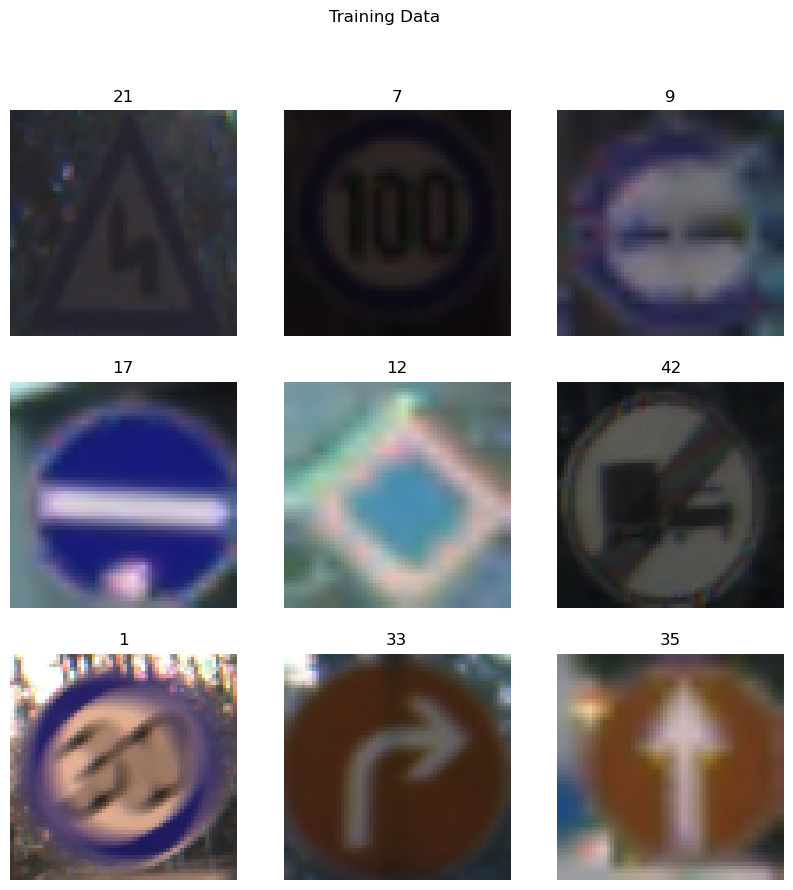

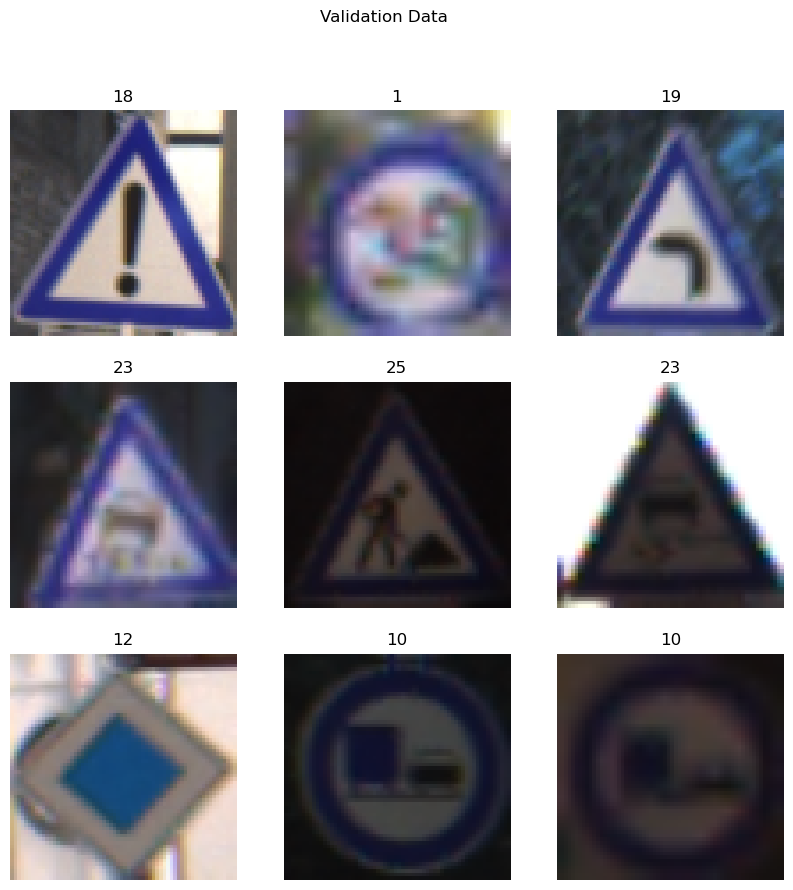

In [5]:
def visualize_data(images, labels, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 sample images
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i]
                # If the images were normalized (e.g., [0, 1]), scale them back to [0, 255]

        if img.max() <= 1.0:  # Check if the image is in [0, 1] range
            img = (img * 255).astype("uint8")  # Rescale to [0, 255] and convert to uint8
        else:  # Original range case
            img = np.clip(img, 0, 255).astype("uint8")  # Ensure values are within [0, 255]
            
        plt.imshow(img)  # Display the image
        plt.title(int(labels[i]))  # Display the class label as the title
        plt.axis("off")
    
    plt.suptitle(title)
    plt.show()

# Visualize training data
visualize_data(X_train, y_train, title="Training Data")

# Visualize validation data
visualize_data(X_val, y_val, title="Validation Data")

# Using image data augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.1),
])


2024-10-06 16:47:27.658545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 16:47:28.151249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4157 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## Visualize augmented data

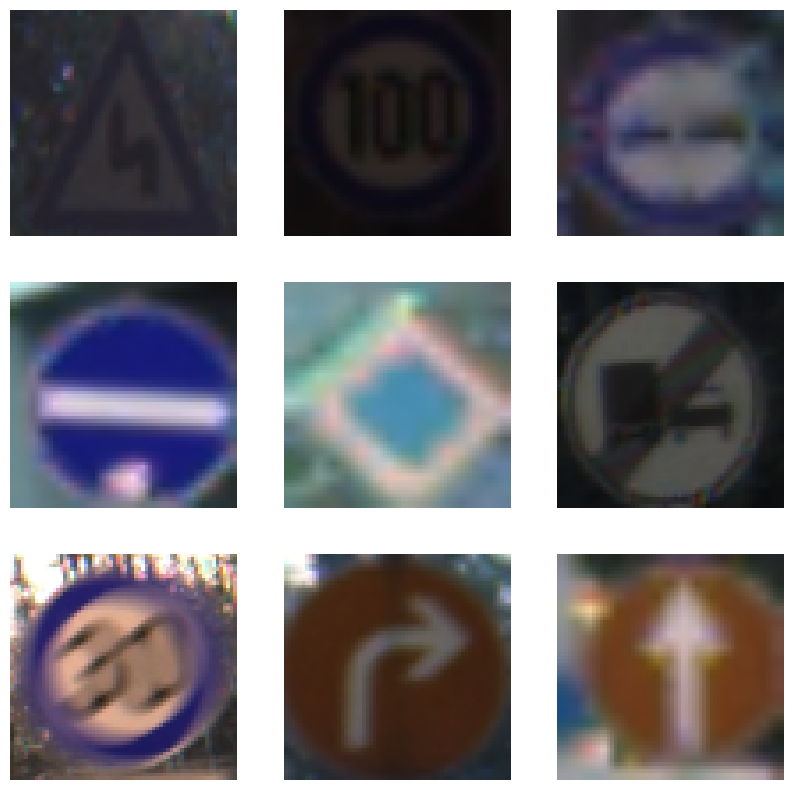

In [7]:
def visualize_augmented_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 augmented sample images
        # Apply augmentation
        augmented_image = data_augmentation(images[i:i+1])  # Augment the image
        
        # Convert back to uint8 if the image is in float format
        if augmented_image.dtype == tf.float32:
            augmented_image = tf.clip_by_value(augmented_image * 255, 0, 255)
            augmented_image = tf.cast(augmented_image, tf.uint8)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy())
        plt.axis("off")
    plt.show()

# Example visualization (on a few training images)
visualize_augmented_images(X_train)

# Build a Model

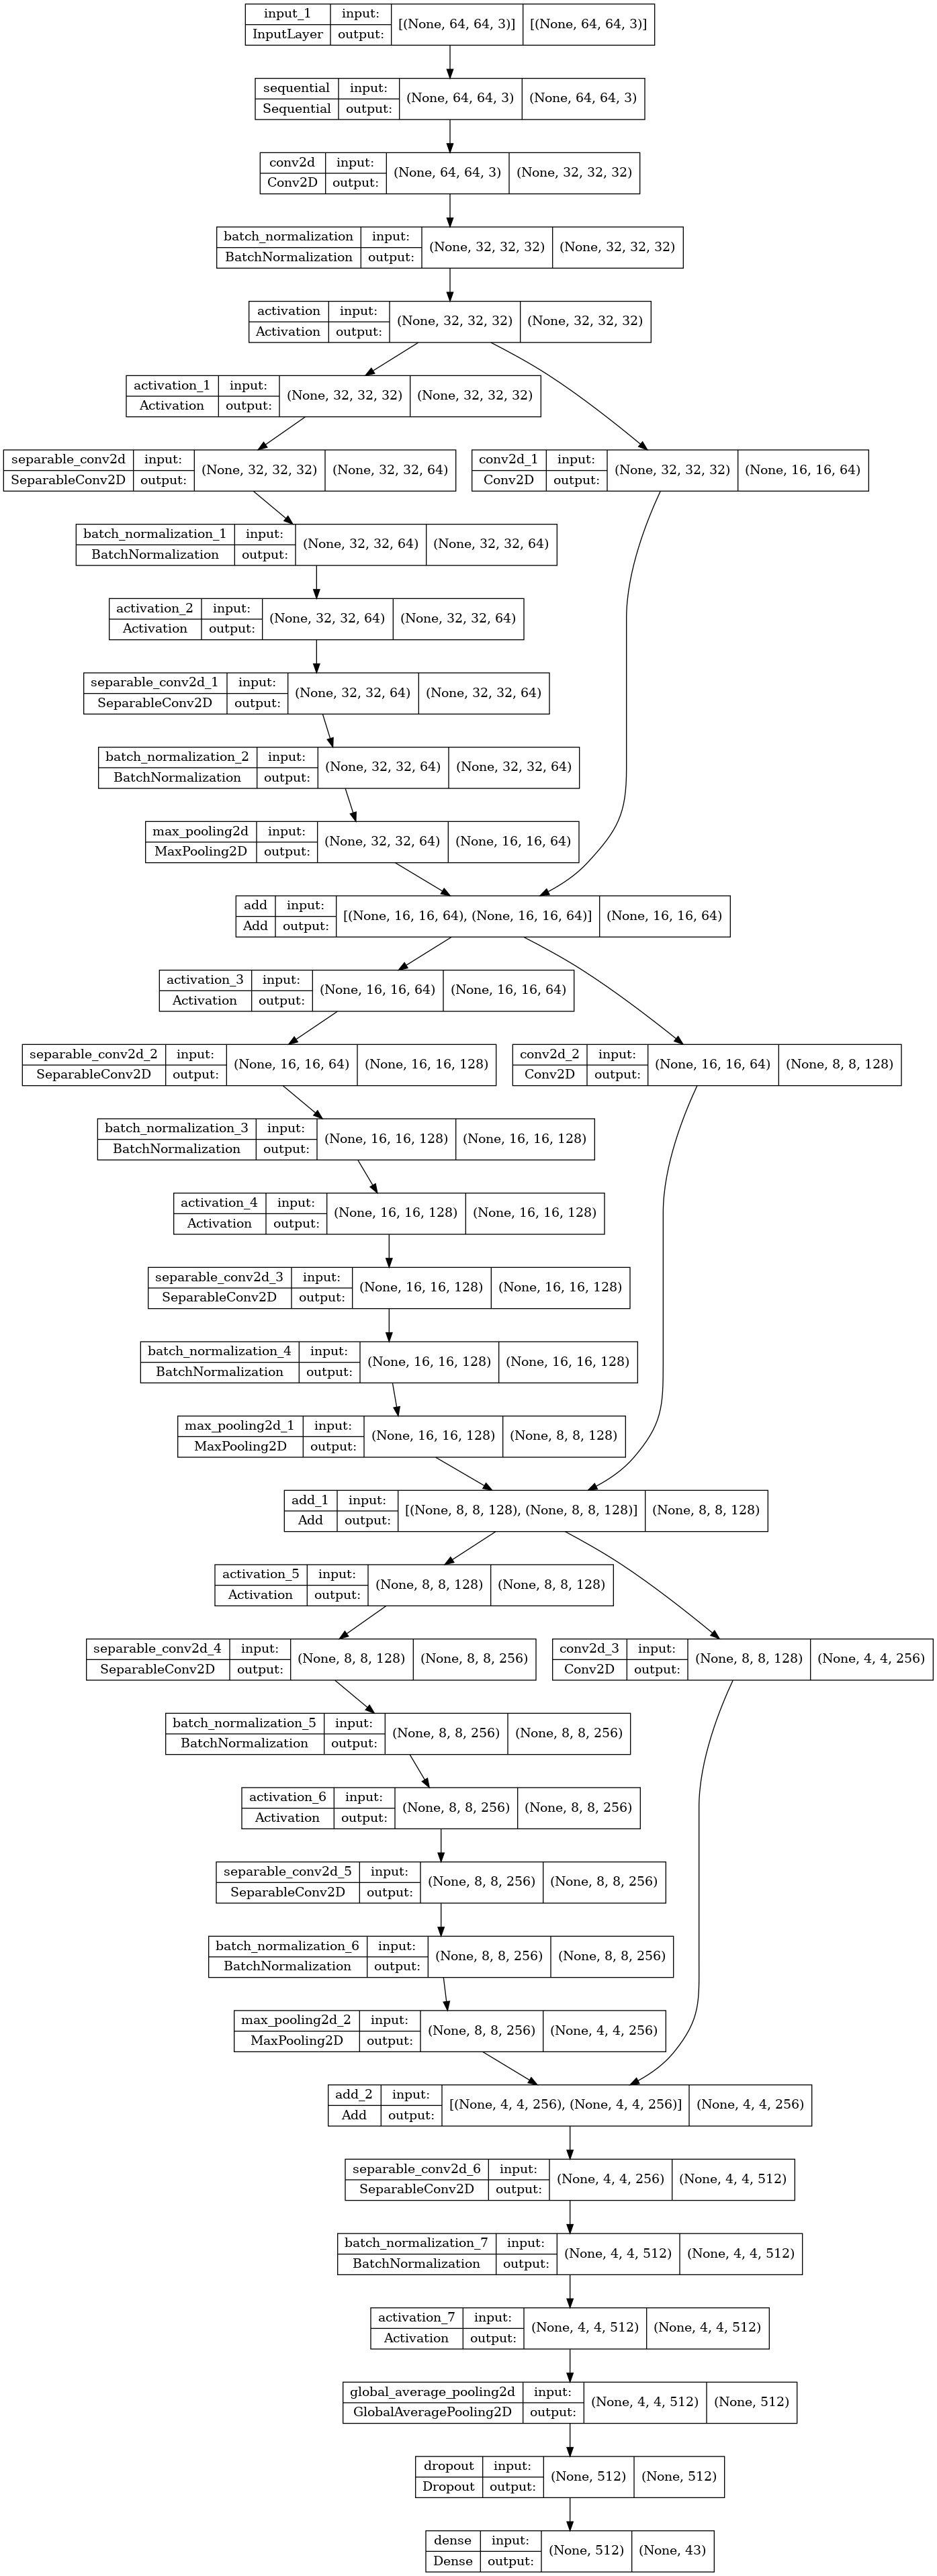

In [8]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = data_augmentation(inputs, training=True)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.50)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=43)
tf.keras.utils.plot_model(model, show_shapes=True)

# Train the Model

In [9]:
# Load the best saved model
model = tf.keras.models.load_model('best_model.keras')

epochs = 25

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1,
    mode='min'
)]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    X_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
    )

2024-10-06 16:47:29.168476: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1541750784 exceeds 10% of free system memory.
2024-10-06 16:47:29.917525: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1541750784 exceeds 10% of free system memory.


Epoch 1/25


2024-10-06 16:47:32.441493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


981/981 [==============================] - ETA: 0s - loss: 2.1160 - accuracy: 0.3610
Epoch 1: val_loss improved from inf to 1.34125, saving model to best_model.keras
981/981 [==============================] - 18s 14ms/step - loss: 2.1160 - accuracy: 0.3610 - val_loss: 1.3413 - val_accuracy: 0.5389
Epoch 2/25
978/981 [============================>.] - ETA: 0s - loss: 1.1176 - accuracy: 0.6264
Epoch 2: val_loss improved from 1.34125 to 0.83275, saving model to best_model.keras
981/981 [==============================] - 13s 13ms/step - loss: 1.1173 - accuracy: 0.6265 - val_loss: 0.8328 - val_accuracy: 0.7191
Epoch 3/25
978/981 [============================>.] - ETA: 0s - loss: 0.7655 - accuracy: 0.7395
Epoch 3: val_loss did not improve from 0.83275
981/981 [==============================] - 13s 13ms/step - loss: 0.7653 - accuracy: 0.7395 - val_loss: 1.0113 - val_accuracy: 0.6798
Epoch 4/25
977/981 [============================>.] - ETA: 0s - loss: 0.5963 - accuracy: 0.7967
Epoch 4: val_lo

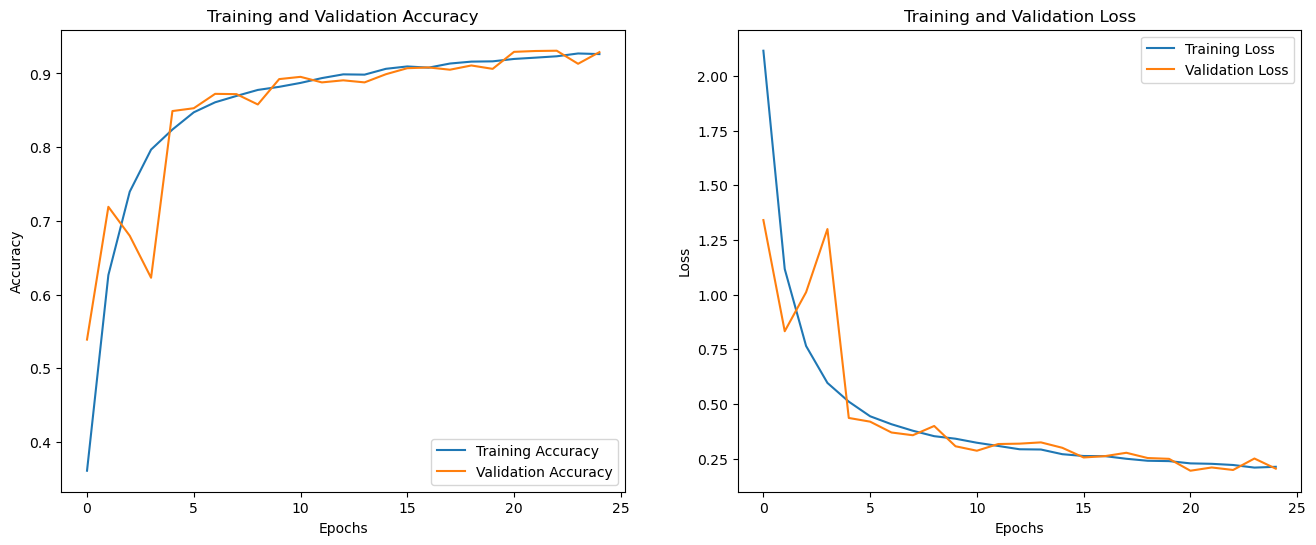

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

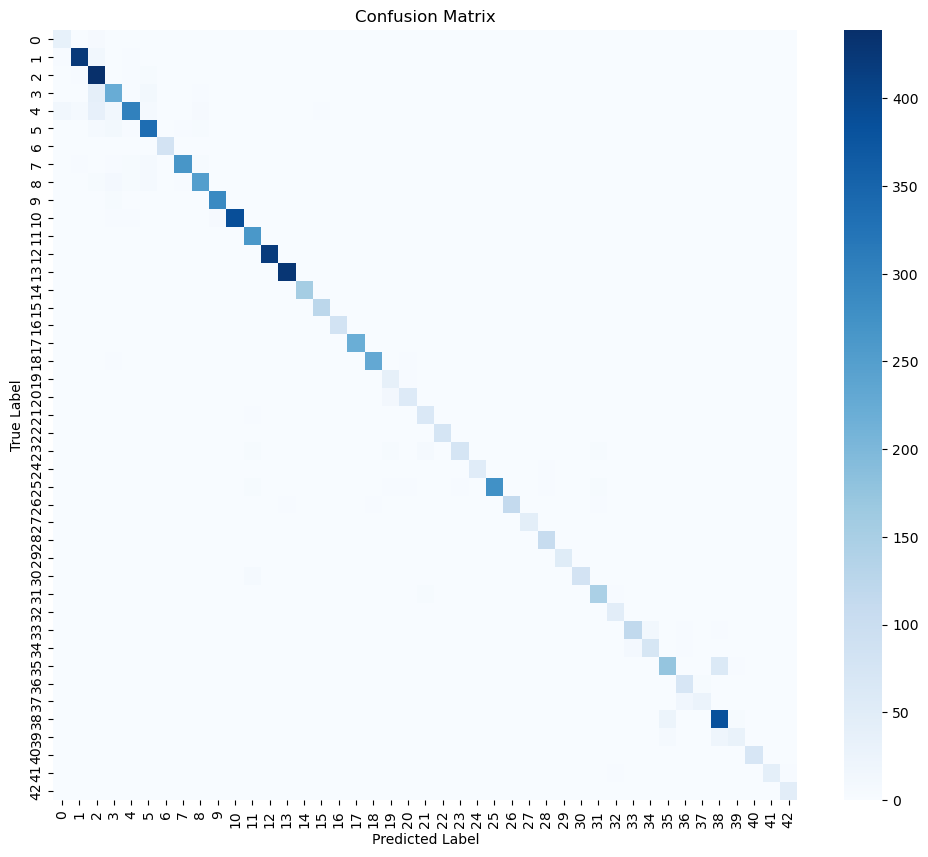

In [11]:
# Predict the labels on the validation dataset
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Load test Images

In [12]:
# Path to the test images and annotations
test_images_path = 'GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/'
test_annotations_file = os.path.join(test_images_path, 'GT-final_test.test.csv')

test_annotations = pd.read_csv(test_annotations_file, sep=';')

test_images = []
test_labels = []
    
for idx, row in annotations.iterrows():
    # Read the image
    image_path = os.path.join(class_path, row['Filename'])
    image = cv2.imread(image_path)
    
    # Crop the image to the Region of Interest (ROI)
    roi = image[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
    
    roi = cv2.resize(roi, image_size)  # Resize to 64x64 pixels
    roi = roi / 255.0  # Normalize pixel values to [0, 1]
    
    # Convert to array and append
    images.append(img_to_array(roi))
    labels.append(row['ClassId'])

# Convert to NumPy arrays
X_test = np.array(images)
y_test = np.array(labels)


In [13]:
del X_train, y_train, X_val, y_val
gc.collect()

22851

# Evaluate the Model on the Test Set

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

2024-10-06 16:53:15.398216: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1938997248 exceeds 10% of free system memory.
2024-10-06 16:53:16.501552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1938997248 exceeds 10% of free system memory.


1233/1233 [==============================] - 6s 5ms/step - loss: 0.1879 - accuracy: 0.9331
Test Loss: 0.1879
Test Accuracy: 0.9331


# Analyze the Model's Performance

## Generate Predictions

In [16]:
# Predict the labels for the test set
y_pred_probs = model.predict(X_test, batch_size=8)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

## Classification Report

In [17]:
print(classification_report(y_test, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.7837    0.9143    0.8440       210
           1     0.9730    0.9590    0.9660      2220
           2     0.7983    0.9853    0.8820      2250
           3     0.8662    0.8170    0.8409      1410
           4     0.9606    0.8374    0.8948      1980
           5     0.9102    0.9097    0.9099      1860
           6     0.9902    0.9619    0.9758       420
           7     0.9838    0.9278    0.9550      1440
           8     0.9505    0.9121    0.9309      1410
           9     0.9644    0.9755    0.9699      1470
          10     0.9954    0.9726    0.9839      2010
          11     0.9387    0.9985    0.9677      1320
          12     0.9967    0.9990    0.9979      2100
          13     0.9777    0.9968    0.9872      2160
          14     0.9974    1.0000    0.9987       780
          15     0.9889    0.9921    0.9905       630
          16     0.9744    0.9952    0.9847       420
          17     0.9991    

## Confusion Matrix

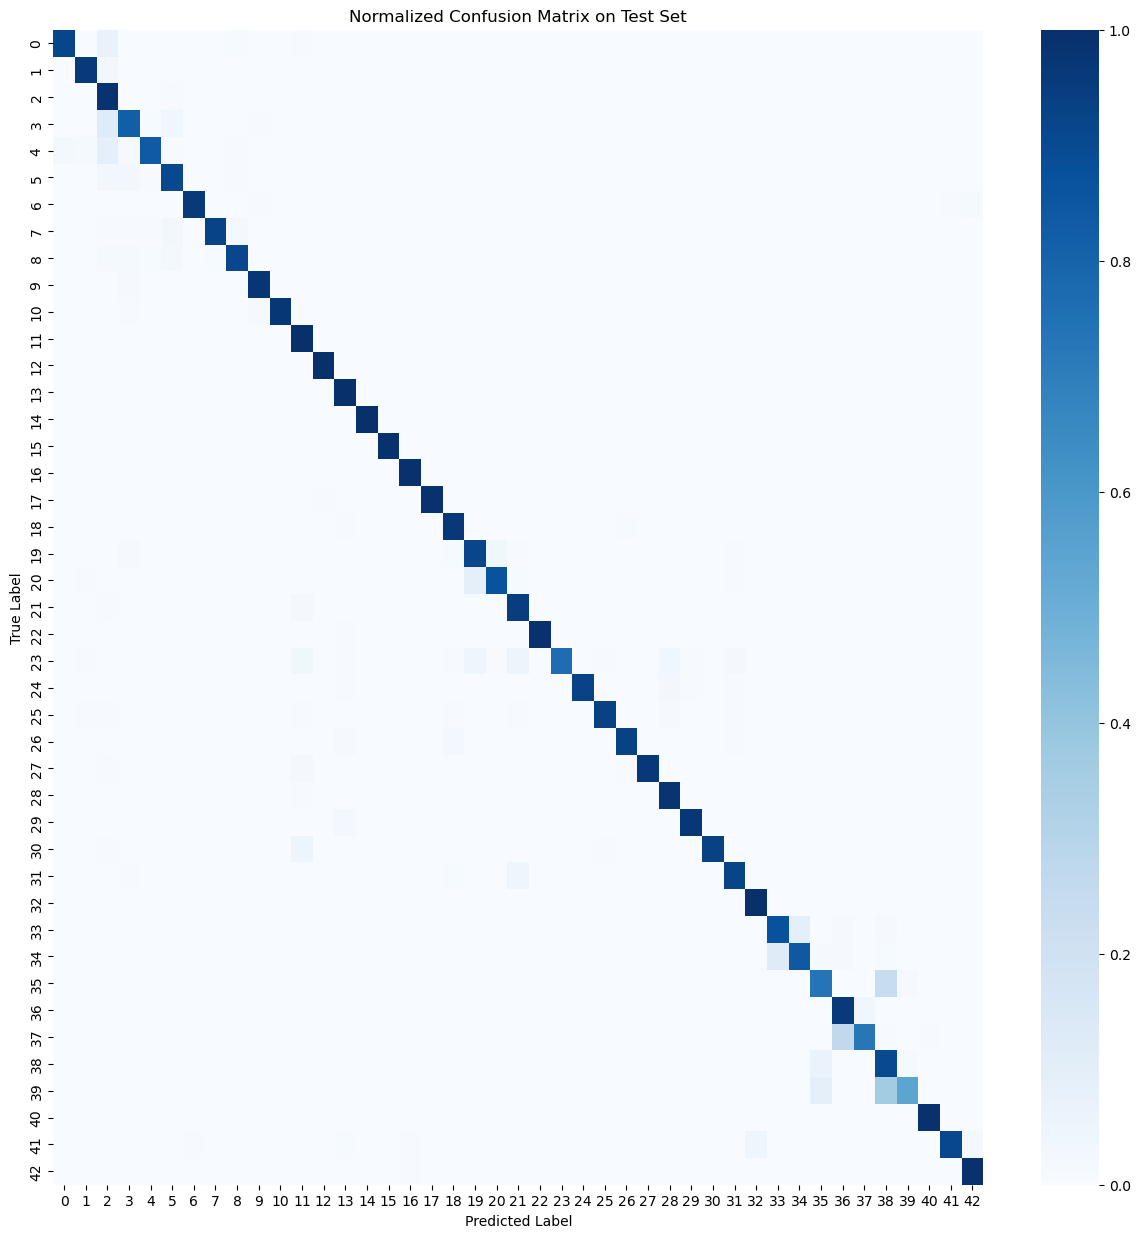

In [18]:
# Compute the confusion matrix
conf_mtx = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix for better visualization
conf_mtx_norm = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_mtx_norm, annot=False, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix on Test Set')
plt.show()

# Visualize Some Test Predictions

In [1]:
def visualize_test_predictions(images, true_labels, predicted_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    indices = np.random.choice(len(images), num_images, replace=False)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        img = images[idx]
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        plt.imshow(img)
        true_label = class_names[true_labels[idx]]
        predicted_label = class_names[predicted_labels[idx]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis("off")
    plt.show()


class_names = {i: f'Class {i}' for i in range(43)} 

visualize_test_predictions(X_test, y_test, y_pred_classes, class_names)

NameError: name 'X_test' is not defined